# EfficientNet Keras - Regression

---

Here in this kernel, we are going to train Efficient Net architecture (pretrained on imagenet) using past competition data (not cropped) as the training set and new competition data as the validation set.

Due to kaggle kernels computing limitations, we are going to load the train set sequentially as I described here: [[APTOS19] DenseNet Trained with Old and New Data](https://www.kaggle.com/raimonds1993/aptos19-densenet-trained-with-old-and-new-data).

[Inference Kernel](https://www.kaggle.com/raimonds1993/aptos19-inference-efficientnet-keras-regression). With this approach, I achieved 0.75 Public LB.

**EDIT:** The score can be improved up to ~ 0.78 just by fine tuning the model on new competition data. So, one could use this as a starting point to build a stronger model. :)

If you enjoyed the kernel, <span style="color:red">**please upvote**</span>. I would really appreciate that!

### Credits

- [APTOS 2019: DenseNet Keras Starter](https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter), by **Xhlulu**

- [Previous competition's data](https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized), uploaded by **ilovescience**

- [Kappa Optimizer](https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa), by **Abhishek**

# EfficientNet

![effnet](https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png)

### [Here is the paper](https://arxiv.org/abs/1905.11946)

> The core idea about Efficient Nets is the use of compound scaling - using a weighted scale of three inter-connected hyper parameters of the model - Resolution of the input, Depth of the Network and Width of the Network.
> 

We are going to use [keras-efficientnets](https://github.com/titu1994/keras-efficientnets) library.

Also [efficientnet](https://github.com/qubvel/efficientnet) library would work fine.

In [21]:
# Libraries
import json
import math
import os


import scipy as sp
from functools import partial
from collections import Counter
import json

import cv2
from PIL import Image
import numpy as np
from keras import backend as K
from keras import layers
from keras_efficientnets import *
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [22]:
# Image size
im_size = 224
# Batch size
BATCH_SIZE = 32

# Loading & Merging

In [23]:
new_train = pd.read_csv('train.csv')
old_train = pd.read_csv('trainLabels (1).csv')
print(new_train.shape)
print(old_train.shape)

(3662, 2)
(35126, 2)


In [24]:
old_train = old_train[['image','level']]
old_train.columns = new_train.columns
old_train.diagnosis.value_counts()

new_train['id_code'] = 'train_images/' + new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = 'resized_train/' + old_train['id_code'].astype(str) + '.jpeg'

train_df = old_train.copy()
val_df = new_train.copy()

In [25]:
val_df

,id_code,diagnosis
0,train_images/000c1434d8d7.png,2
1,train_images/001639a390f0.png,4
2,train_images/0024cdab0c1e.png,1
3,train_images/002c21358ce6.png,0
4,train_images/005b95c28852.png,0
...,...,...
3657,train_images/ffa47f6a7bf4.png,2
3658,train_images/ffc04fed30e6.png,0
3659,train_images/ffcf7b45f213.png,2
3660,train_images/ffd97f8cd5aa.png,0


In [26]:
train_df

,id_code,diagnosis
0,resized_train/10_left.jpeg,0
1,resized_train/10_right.jpeg,0
2,resized_train/13_left.jpeg,0
3,resized_train/13_right.jpeg,0
4,resized_train/15_left.jpeg,1
...,...,...
35121,resized_train/44347_right.jpeg,0
35122,resized_train/44348_left.jpeg,0
35123,resized_train/44348_right.jpeg,0
35124,resized_train/44349_left.jpeg,0


In [27]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(35126, 2)
(3662, 2)


In [28]:
import cv2

In [29]:
cv2.data.haarcascades

'C:\\Users\\kratika\\Anaconda3\\lib\\site-packages\\cv2\\data\\'

resized_train/12563_left.jpeg
resized_train/39453_left.jpeg
resized_train/44095_right.jpeg
resized_train/25650_right.jpeg
resized_train/43008_left.jpeg
resized_train/3359_left.jpeg
resized_train/5421_left.jpeg
resized_train/13267_left.jpeg
resized_train/4253_right.jpeg
resized_train/24405_left.jpeg
resized_train/12225_right.jpeg
resized_train/25637_left.jpeg


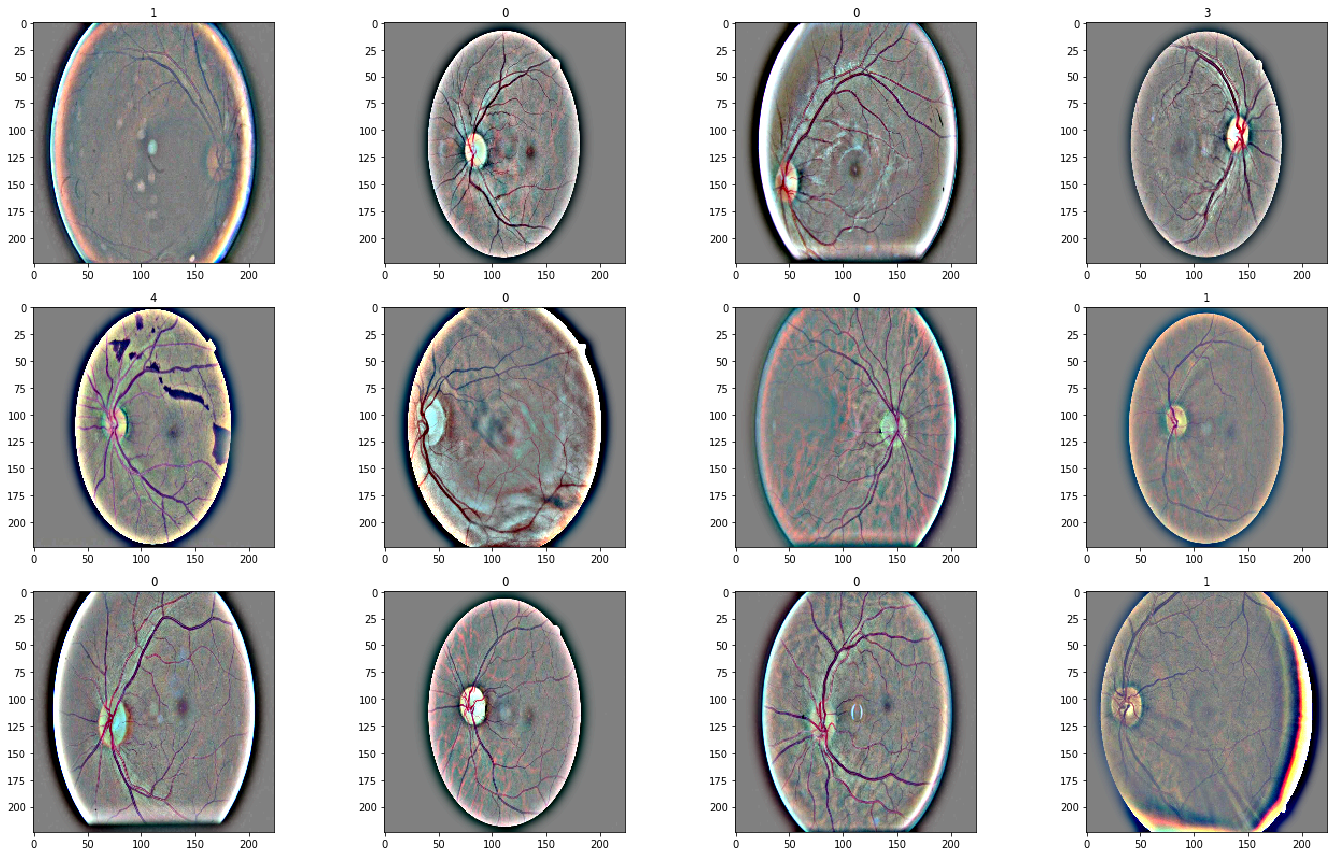

In [30]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        print(image_path)
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

# display train images
display_samples(train_df)

# Process Images

After this [thread](https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/100815#latest-582932), I changed the training set (old comp data) preprocessing. 

Now, instead of cropping images, I'm using more trainsformations in `ImageDataGenerator`, such as: 

- `featurewise_std_normalization`
- `horizontal_flip`
- `vertical_flip`
- `rotation_range`
- `zoom_range`

In [31]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/30) ,-4 ,128)
    
    return img

def preprocess_image_old(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

In [33]:
N = val_df.shape[0]
x_val = np.empty((N, im_size, im_size, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['id_code'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

error: OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [34]:
y_train = train_df['diagnosis'].values
y_val = val_df['diagnosis'].values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(35126,)
(3662, 224, 224, 3)
(3662,)


In [35]:
del new_train
del old_train
del val_df
gc.collect()

29236

# Creating keras callback for QWK

In [36]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        
        y_pred = self.model.predict(X_val)
        
        coef = [0.5, 1.5, 2.5, 3.5]

        for i, pred in enumerate(y_pred):
            if pred < coef[0]:
                y_pred[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                y_pred[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                y_pred[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                y_pred[i] = 3
            else:
                y_pred[i] = 4

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Data Generator

In [37]:
def create_datagen():
    return ImageDataGenerator(
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 160,
        zoom_range=0.35
    )

# Model: EfficientNetB5

In [39]:
effnet = EfficientNetB5(
    input_shape=(im_size,im_size,3),
    weights='imagenet',
    include_top=False
)

 36855808/115295288 [========>.....................] - ETA: 25:3 - ETA: 16:1 - ETA: 18:5 - ETA: 9:4 - ETA: 10:0 - ETA: 10:5 - ETA: 9:1 - ETA: 8: - ETA: 7: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA

 78635008/115295288 [===================>..........] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1:50

ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

In [42]:
def build_model():
    model = Sequential()
    model.add(effnet)
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(2048))
    model.add(layers.LeakyReLU())
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(lr=0.0001,decay=1e-5),
        metrics=['mae']
    )
    
    return model

In [43]:
model = build_model()
model.summary()

NameError: name 'effnet' is not defined

# Training & Evaluation

In [18]:
num_bucket = 8
div = round(train_df.shape[0]/num_bucket)
div

4391

In [19]:
results = pd.DataFrame({
                        'val_loss': [0.0],
                        'val_mean_absolute_error': [0.0],
                        'loss': [0.0], 
                        'mean_absolute_error': [0.0],
                        'bucket': [0.0]
                        })

In [20]:
# Epochs
epochs = [10,10,10,15,15,20,20,25]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

In [21]:
for i in range(0,num_bucket):
    if i != (num_bucket-1):
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image_old(f'{image_id}', desired_size = im_size)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div], batch_size=BATCH_SIZE)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image_old(f'{image_id}', desired_size = im_size)
        data_generator = create_datagen().flow(x_train, y_train[i*div:], batch_size=BATCH_SIZE)
        
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)
    
    del data_generator
    del x_train
    gc.collect()
    
    print('-'*40)

Bucket Nr: 0



Epoch 1/10
138/137 [==============================] - 200s 1s/step - loss: 1.0107 - mean_absolute_error: 0.7620 - val_loss: 0.9195 - val_mean_absolute_error: 0.6894
val_kappa: 0.5709
Validation Kappa has improved. Saving model.
Epoch 2/10
138/137 [==============================] - 145s 1s/step - loss: 0.7998 - mean_absolute_error: 0.6732 - val_loss: 0.9147 - val_mean_absolute_error: 0.6938
val_kappa: 0.7601
Validation Kappa has improved. Saving model.
Epoch 3/10
138/137 [==============================] - 145s 1s/step - loss: 0.7129 - mean_absolute_error: 0.6264 - val_loss: 0.7214 - val_mean_absolute_error: 0.6896
val_kappa: 0.7238
Epoch 4/10
138/137 [==============================] - 145s 1s/step - loss: 0.6547 - mean_absolute_error: 0.5918 - val_loss: 0.8949 - val_mean_absolute_error: 0.8133
val_kappa: 0.6760
Epoch 5/10
138/137 [==============================] - 145s 1s/step - loss: 0.6056 - mean_absolute_error: 0.5662 - val_loss: 0.7427 - val_mean_absolute_error: 0.5904
val_kappa: 0


Epoch 1/10
138/137 [==============================] - 145s 1s/step - loss: 0.5676 - mean_absolute_error: 0.5319 - val_loss: 0.5945 - val_mean_absolute_error: 0.6223
val_kappa: 0.7939
Epoch 2/10
138/137 [==============================] - 145s 1s/step - loss: 0.5046 - mean_absolute_error: 0.4965 - val_loss: 0.6194 - val_mean_absolute_error: 0.6327
val_kappa: 0.8133
Epoch 3/10
138/137 [==============================] - 145s 1s/step - loss: 0.4866 - mean_absolute_error: 0.4839 - val_loss: 0.6082 - val_mean_absolute_error: 0.6423
val_kappa: 0.8028
Epoch 4/10
138/137 [==============================] - 144s 1s/step - loss: 0.4585 - mean_absolute_error: 0.4640 - val_loss: 0.4432 - val_mean_absolute_error: 0.4592
val_kappa: 0.8582
Validation Kappa has improved. Saving model.
Epoch 5/10
138/137 [==============================] - 145s 1s/step - loss: 0.4393 - mean_absolute_error: 0.4546 - val_loss: 0.5135 - val_mean_absolute_error: 0.4959
val_kappa: 0.7914
Epoch 6/10
138/137 [===================


Epoch 1/10
138/137 [==============================] - 145s 1s/step - loss: 0.5552 - mean_absolute_error: 0.5092 - val_loss: 0.5443 - val_mean_absolute_error: 0.5089
val_kappa: 0.8440
Epoch 2/10
138/137 [==============================] - 145s 1s/step - loss: 0.4948 - mean_absolute_error: 0.4826 - val_loss: 0.5525 - val_mean_absolute_error: 0.5737
val_kappa: 0.8233
Epoch 3/10
138/137 [==============================] - 144s 1s/step - loss: 0.4608 - mean_absolute_error: 0.4627 - val_loss: 0.4301 - val_mean_absolute_error: 0.4415
val_kappa: 0.8599
Validation Kappa has improved. Saving model.
Epoch 4/10
138/137 [==============================] - 145s 1s/step - loss: 0.4190 - mean_absolute_error: 0.4367 - val_loss: 0.4666 - val_mean_absolute_error: 0.4270
val_kappa: 0.8165
Epoch 5/10
138/137 [==============================] - 144s 1s/step - loss: 0.4238 - mean_absolute_error: 0.4418 - val_loss: 0.5676 - val_mean_absolute_error: 0.5467
val_kappa: 0.8155
Epoch 6/10
138/137 [===================


Epoch 1/15
138/137 [==============================] - 145s 1s/step - loss: 0.5263 - mean_absolute_error: 0.4995 - val_loss: 0.5112 - val_mean_absolute_error: 0.4858
val_kappa: 0.8564
Epoch 2/15
138/137 [==============================] - 147s 1s/step - loss: 0.4658 - mean_absolute_error: 0.4636 - val_loss: 0.4104 - val_mean_absolute_error: 0.4360
val_kappa: 0.8584
Epoch 3/15
138/137 [==============================] - 148s 1s/step - loss: 0.4297 - mean_absolute_error: 0.4407 - val_loss: 0.5503 - val_mean_absolute_error: 0.5627
val_kappa: 0.8432
Epoch 4/15
138/137 [==============================] - 148s 1s/step - loss: 0.4039 - mean_absolute_error: 0.4308 - val_loss: 0.4506 - val_mean_absolute_error: 0.4610
val_kappa: 0.8523
Epoch 5/15
138/137 [==============================] - 148s 1s/step - loss: 0.3718 - mean_absolute_error: 0.4022 - val_loss: 0.4599 - val_mean_absolute_error: 0.4268
val_kappa: 0.8543
Epoch 6/15
138/137 [==============================] - 148s 1s/step - loss: 0.3536 - 


Epoch 1/15
138/137 [==============================] - 149s 1s/step - loss: 0.5163 - mean_absolute_error: 0.4983 - val_loss: 0.4899 - val_mean_absolute_error: 0.5254
val_kappa: 0.8472
Epoch 2/15
138/137 [==============================] - 148s 1s/step - loss: 0.4523 - mean_absolute_error: 0.4608 - val_loss: 0.4293 - val_mean_absolute_error: 0.4842
val_kappa: 0.8655
Validation Kappa has improved. Saving model.
Epoch 3/15
138/137 [==============================] - 149s 1s/step - loss: 0.4186 - mean_absolute_error: 0.4439 - val_loss: 0.5136 - val_mean_absolute_error: 0.5535
val_kappa: 0.8406
Epoch 4/15
138/137 [==============================] - 148s 1s/step - loss: 0.3754 - mean_absolute_error: 0.4191 - val_loss: 0.4239 - val_mean_absolute_error: 0.4461
val_kappa: 0.8492
Epoch 5/15
138/137 [==============================] - 149s 1s/step - loss: 0.3591 - mean_absolute_error: 0.4025 - val_loss: 0.5827 - val_mean_absolute_error: 0.5510
val_kappa: 0.8358
Epoch 6/15
138/137 [===================

In [22]:
results = results.iloc[1:]
results['kappa'] = kappa_metrics.val_kappas
results = results.reset_index()
results = results.rename(index=str, columns={"index": "epoch"})
print(max(results.kappa))

0.8800029790943319


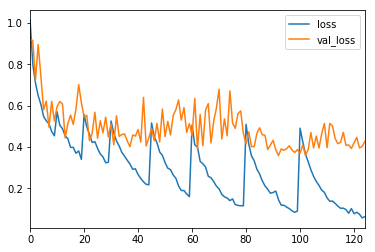

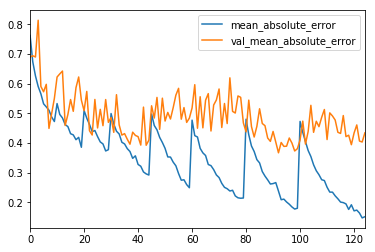

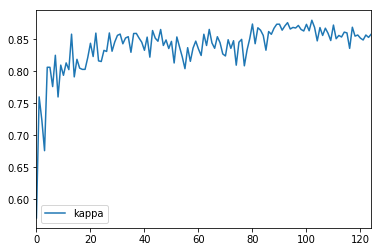

In [23]:
results[['loss', 'val_loss']].plot()
results[['mean_absolute_error', 'val_mean_absolute_error']].plot()
results[['kappa']].plot()
results.to_csv('model_results.csv',index=False)

# Kappa Optimizer

In [24]:
#https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

# Results

In [25]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

optR = OptimizedRounder()
optR.fit(y_val_pred, y_val)
coefficients = optR.coefficients()
print(f'Coefficients: {coefficients}')
y_val_pred = optR.predict(y_val_pred, coefficients)

score = cohen_kappa_score(y_val_pred, y_val, weights='quadratic')

print('Optimized Validation QWK score: {}'.format(score))
print('Not Optimized Validation QWK score: {}'.format(max(results.kappa)))

0.8849103444249242
Coefficients: [0.60513711 1.36421993 2.52844061 3.07940899]
Optimized Validation QWK score: 0.8849103444249242
Not Optimized Validation QWK score: 0.8800029790943319


**Thanks for reading it all! Please let me know if you have any ideas to improve this process. Hope you liked it.**